<a href="https://colab.research.google.com/github/WelfLowe/ML4developers/blob/main/6_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artificial Neural Networks (ANN)

ANN can be used for classification and for regression tasks. Below we demonstrate both.

## ANN for classification

This is first part merely a copy of the tutorial on "Gradient descent on a Softmax cross-entropy cost function" found [here](https://madalinabuzau.github.io/2016/11/29/gradient-descent-on-a-softmax-cross-entropy-cost-function.html).

I adapted it to our running example of Iris classification and added history plots and some documentation.

Import useful libraries.

In [74]:
from sklearn.datasets import make_classification 
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

import pandas as pd
import sys

Import Iris data.

In [75]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

Create a class for a Softmax linear classifier. Methods:
* $\verb|get_loss_grads|$ returns the gradients of the loss wrt. the weights and biases. It is used internally in the gradient descent methods.
* $\verb|train|$ optimizes the loss using gradient descent for a fixed number of iterations, i.e., it trains the model by iteratively adjusting the initial weights and biases in the direction of the negative gradient vector with smaller and smaller steps as the gradient vector approaches zero.  
* $\verb|train_early_stopping|$ same as $\verb|train|$, but it only stops if the accuracy on the validation set doesn't improve for a number of iterations.
* $\verb|predict|$ uses the model, i.e., the current weights and biases, for predicting classes.
* $\verb|eval|$ uses the model, i.e., the current weights and biases, for evaluating the accuraxy of the prdiction.

In [76]:
class Softmax(object):    

  def __init__(self):
    self.W = None
    self.b = None
    self.history = []
    
  def get_loss_grads(self, X, y, reg, n_samples):  
    # Linear mapping scores
    scores = np.dot(X, self.W)+self.b

    # Normalize the scores beforehand with max as zero to avoid 
    # computational problems with the exponential
    exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))

    # Softmax activation
    probs = exp_scores/np.sum(exp_scores, axis=1, keepdims=True)
    # Logloss of the correct class for each of our samples
    correct_logprobs = -np.log(probs[np.arange(n_samples), y])

    # Compute the average loss
    loss = np.sum(correct_logprobs)/n_samples

    # Add regularization using the L2 norm
    reg_loss = 0.5*reg*np.sum(self.W*self.W)
    loss += reg_loss
    
    # Gradient of the loss with respect to scores
    dscores = probs.copy()

    # Substract 1 from the scores of the correct class
    dscores[np.arange(n_samples),y] -= 1
    dscores /= n_samples

    # Gradient of the loss with respect to weights
    dW = X.T.dot(dscores) 

    # Add gradient regularization 
    dW += reg*self.W

    # Gradient of the loss with respect to biases
    db = np.sum(dscores, axis=0, keepdims=True)

    return loss, dW, db


  def train(self, X, y, learning_rate=1e-4, reg=0.5, num_iters=500):
    # Get useful parameters
    n_features = X.shape[1]   
    n_samples = X.shape[0] 
    n_classes = len(np.unique(y))
    
    # Initialize weights from a normal distribution and the biases with zeros
    if (self.W is None) & (self.b is None):
      np.random.seed(2016) # for reproducible results
      self.W = np.random.normal(loc=0.0, scale=1e-4, size=(n_features, n_classes))
      self.b = np.zeros((1, n_classes))
        
    for iter in range(num_iters):
      # Get loss and gradients
      loss, dW, db = self.get_loss_grads(X, y, reg, n_samples)
      
      # update weights and biases
      self.W -= learning_rate*dW
      self.b -= learning_rate*db

      # Compute validation accuracy
      accuracy = self.eval(X,y)
      self.history.append(accuracy)
        
        
  def train_early_stopping(self, X_train, y_train, X_val, y_val, learning_rate=1e-4, reg=0.5, early_stopping_rounds=200):
    # Get useful parameters_train
    n_features = X_train.shape[1]   
    n_samples = X_train.shape[0] 
    n_classes = len(np.unique(y))
    
    # Initialize weights from a normal distribution and the biases with zeros
    if (self.W is None) & (self.b is None):
      np.random.seed(2016) # for reproducible results
      self.W = np.random.normal(loc=0.0, scale=1e-4, size=(n_features, n_classes))
      self.b = np.zeros((1, n_classes))

    # Stores best accuracy found 
    best_val_accuracy = -1
    
    # Stores the weights and biases of the best iteration
    best_weights, best_bias = None, None
    
    # Counts the number of no improvements in the accuracy
    no_improvement = 0
    
    # Boolean variable which helps us get out of the while loop
    keep_training = True
        
    while keep_training:
        
      # Get loss and gradients
      loss, dW, db = self.get_loss_grads(X_train, y_train, reg, n_samples)
    
      # update weights and biases
      self.W -= learning_rate*dW
      self.b -= learning_rate*db
              
      # Compute validation accuracy
      val_accuracy = self.eval(X_val,y_val)
      train_accuracy = self.eval(X_train,y_train)

      self.history.append([val_accuracy,train_accuracy])

      if val_accuracy>best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_weights, best_bias = self.W, self.b
        # reset count
        no_improvement = 0
      else:
        no_improvement += 1
        
      if no_improvement == early_stopping_rounds:
        self.W, self.b = best_weights, best_bias
        keep_training = False
      
      
  def predict(self, X):
    y_pred = np.dot(X, self.W)+self.b
    y_pred=np.argmax(y_pred, axis=1)

    return y_pred

  def eval(self, X, y):
    return np.mean(self.predict(X)==y)

Function for plotting the training history.

In [77]:
def plot_history(history, labels):
  x = range(len(history))
  hist_arr = np.asarray(history)
  if hist_arr.ndim==1:
    plt.plot(x, hist_arr, label=labels );
  else:
    i = 0
    for hist_row in hist_arr.transpose():
      plt.plot(x, hist_row, label = labels[i]);
      i += 1 
    
  plt.title("Improvement of model performance over epochs")
  plt.xlabel("epochs")
  plt.ylabel("performance");
  plt.legend();

Train and assess the model on the whole dataset using a fixed number of training iterations.

Accuracy 0.8866666666666667


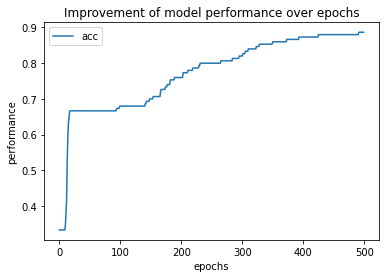

In [78]:
softmax = Softmax()
softmax.train( X, y, learning_rate=1e-2, reg=0.1, num_iters=500)
print('Accuracy', softmax.eval(X, y))
plot_history(softmax.history, 'acc')

Train and assess the model on the dataset split into training and validation subsets using early stopping.

Training accuracy 0.95
Validation accuracy 1.0


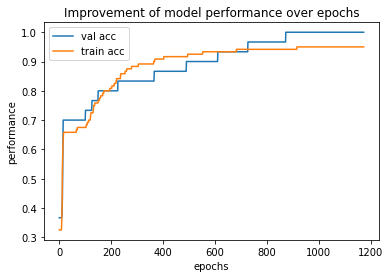

In [79]:
# Split dataset into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) #random_state=2

# Train with early stopping
softmax = Softmax()
softmax.train_early_stopping( X_train, y_train, X_val, y_val, learning_rate=1e-2, reg=0.1, early_stopping_rounds=300)
print('Training accuracy', softmax.eval(X_train, y_train))
print('Validation accuracy', softmax.eval(X_val, y_val))
plot_history(softmax.history, ['val acc', 'train acc'])

## ANN for regression

This second part uses a similar ANN approach for regression. Softmax is not applicable here as we don't want to restrict the output to values between 0 and 1. Also, we use the mean squared error (MSE) as the loss function instead of cross-entropy. This makes it essentially equivalent to linear regression. In is only interesting as the first step towards deep learning where we use several ANN layers and non-linear activation function to regress general functions.

We import the Boston dataset.

In [80]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"
df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
df.columns = ['CRIM','ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df_X = df.drop('MEDV',axis=1)
df_y =df['MEDV']
X = df_X.to_numpy()
y = df_y.to_numpy()
print(X.shape,y.shape)

(484, 13) (484,)


Here the essential changes.

We implement the Glorot uniform initializer for setting the initial weights. It draws samples from a uniform random distribution in $-\textit{limit},\textit{limit}$  where $\textit{limit} = \sqrt{6/(\textit{idg}+\textit{odg})}$, and where $\textit{idg}$ and $\textit{odg}$ are the number of input (equals the number of features) and output nodes (equals 1), resp. The initial bias $b$ is initiall set to $0$.

Prediction works as before whereas evaluation uses MSE.

The gradients of the weights and the bias, resp., can be derived using the chain rule of the definitions of MSE and the linear prediction functions. They are calculated as below. 

In [81]:
n_features, n_samples = X.shape[1], X.shape[0]
limit = np.sqrt(6/(n_features+1))
np.random.seed(42) # for reproducible results
W = np.random.uniform(low=-1*limit, high=limit, size=n_features)
b = 0
y_hat = np.dot(X, W)+b #predict
mse = ((y - y_hat)**2).mean() #eval = mse

dW = -2*X.T.dot(y - y_hat) /n_samples
db = -2*np.sum(y - y_hat) /n_samples

mse

77753.44563246238

Given these changes, the regressor class is very similar to the softmax class. Note that in early stopping, MSE is expected to decrease for regression while accuracy is expected to increas. For deciding the stop criterion, we also add an epsilon of 0.1 to consider only significant improvements.

In [82]:
class Regressor(object):    

  def __init__(self):
    self.W = None
    self.b = 0
    self.history = []
    
  def get_loss_grads(self, X, y, reg, n_samples):  
    # Linear mapping scores
    y_hat = np.dot(X, self.W)+self.b

    # Compute the average loss
    mse = ((y - y_hat)**2).mean()

    # Add regularization using the L2 norm
    reg_loss = 0.5*reg*np.sum(self.W*self.W)
    mse += reg_loss
    
    # Gradient of the loss with respect to weights
    dW = -2 * X.T.dot(y - y_hat) /n_samples

    # Add gradient regularization 
    dW += reg*self.W

    # Gradient of the loss with respect to biases
    db = -2 * np.sum(y - y_hat) /n_samples

    return mse, dW, db

  def init_weights(self, n_features): 
    # Initialize weights from a normal distribution and the biases with zeros
    if (self.W is None):
      np.random.seed(42) # for reproducible results
      limit = np.sqrt(6/(n_features+1))
      self.W = np.random.uniform(low=-1*limit, high=limit, size=n_features)

  def train(self, X, y, learning_rate=1e-4, reg=0, num_iters=50):
    # Get useful parameters
    n_features = X.shape[1]   
    n_samples = X.shape[0] 
    self.init_weights(n_features)
    
    for iter in range(num_iters):
      # Get loss and gradients
      mse, dW, db = self.get_loss_grads(X, y, reg, n_samples)
      
      # update weights and biases
      self.W -= learning_rate*dW
      self.b -= learning_rate*db

      # Compute validation accuracy
      mse = self.eval(X, y)
      self.history.append(mse)
        
        
  def train_early_stopping(self, X_train, y_train, X_val, y_val, learning_rate=1e-4, reg=0.5, early_stopping_rounds=200):
    # Get useful parameters_train
    n_features = X_train.shape[1]   
    n_samples = X_train.shape[0] 
    self.init_weights(n_features)

    # Stores best accuracy found 
    best_val_mse = sys.float_info.max
    
    # Stores the weights and biases of the best iteration
    best_weights, best_bias = None, None
    
    # Counts the number of no improvements in the accuracy
    no_improvement = 0
    
    # Boolean variable which helps us get out of the while loop
    keep_training = True
        
    while keep_training:
        
      # Get loss and gradients
      mse, dW, db = self.get_loss_grads(X_train, y_train, reg, n_samples)
    
      # update weights and biases
      self.W -= learning_rate*dW
      self.b -= learning_rate*db
              
      # Compute validation accuracy
      val_mse = self.eval(X_val,y_val)
      train_mse = self.eval(X_train,y_train)

      self.history.append([val_mse,train_mse])

      if val_mse + 0.1 < best_val_mse: #epsilon = 0.1
        best_val_mse = val_mse
        best_weights, best_bias = self.W, self.b
        # reset count
        no_improvement = 0
      else:
        no_improvement += 1
        
      if no_improvement == early_stopping_rounds:
        self.W, self.b = best_weights, best_bias
        keep_training = False
      
      
  def predict(self, X):
    y_hat = np.dot(X, self.W)+self.b
    return y_hat

  def eval(self, X, y):
    y_hat = self.predict(X)
    return ((y - y_hat)**2).mean()

Training with a fixed number of 1000 iterations. Mind the changed learning rate.

MSE 133.44673063538275


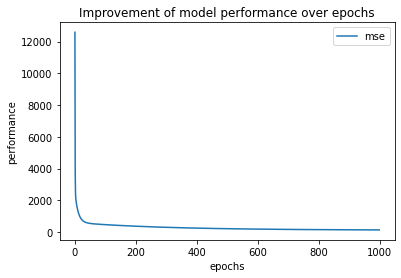

In [83]:
np.random.seed(42) # for reproducible results

regressor = Regressor()
regressor.train( X, y, learning_rate=1e-6, reg=0.1, num_iters=1000)
print('MSE', regressor.eval(X, y))
plot_history(regressor.history, 'mse')

Training and evaluating with early stopping.

Training MSE 121.54840464468273
Validation MSE 103.81981067162394


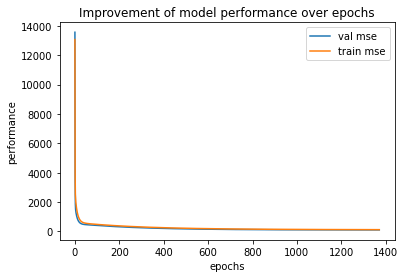

In [84]:
np.random.seed(42) # for reproducible results

# Split dataset into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) 

# Train with early stopping
regressor = Regressor()
regressor.train_early_stopping( X_train, y_train, X_val, y_val, learning_rate=1e-6, reg=0.1, early_stopping_rounds=10)
print('Training MSE', regressor.eval(X_train, y_train))
print('Validation MSE', regressor.eval(X_val, y_val))
plot_history(regressor.history, ['val mse', 'train mse'])

## Advanced: Two Layer ANN and Back-Propagation 

Under construction! Clues frome [here](https://www.youtube.com/watch?v=dxZ8a-oIu7U).

In [85]:
X = X.T
y = y.reshape(1, -1)
print(X.shape, y.shape)

(13, 484) (1, 484)


In [86]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))
  

In [87]:
np.random.seed(42) # for reproducible results

n_features, n_samples = X.shape[0], X.shape[1]
limit1 = np.sqrt(6/(n_features+3))
W1 = np.random.uniform(low=-limit1, high=limit1, size=(3, n_features))
b1 = np.zeros((3,1))
limit2 = np.sqrt(6/(3+1))
W2 = np.random.uniform(low=-limit2, high=limit2, size=(1, 3))
b2 = np.zeros((1,1))

#predict
y1 = np.matmul(W1, X)+b1 # level 1 neurons
s=sigmoid(y1)
y2 = np.matmul(W2, s)+b2 # level 2 neurons

#eval 
mse = ((y - y2)**2).mean() #eval = mse

#gradients
dy2 = 2 *(y2-y)
dW2 = np.matmul(dy2, s.T) 
db2 = np.matmul(dy2, np.ones((n_samples,1)))
ds = np.matmul(W2.T, dy2) 
dy1 = ds * s * sigmoid(1-y1)
dW1 = np.matmul(dy1, X.T) 
db1 = np.matmul(dy1, np.ones((n_samples,1))) 

#check shapes
print(W1.shape,dW1.shape)
print(b1.shape,db1.shape)
print(W2.shape,dW2.shape)
print(b2.shape,db2.shape)

(3, 13) (3, 13)
(3, 1) (3, 1)
(1, 3) (1, 3)
(1, 1) (1, 1)


In [88]:
class Regressor2(object):    

  def __init__(self):
    self.W1 = None
    self.b1 = None
    self.W2 = None
    self.b2 = None
    self.n_features = 0
    self.n_samples = 0
    self.history = []
    
  def get_loss_grads(self, X, y, reg):  
    #predict
    y1 = np.matmul(self.W1, X)+self.b1 # level 1 neurons
    s=sigmoid(y1)
    y2 = np.matmul(self.W2, s)+self.b2 # level 2 neurons

    #gradients
    dy2 = 2 *(y2-y)
    dW2 = np.matmul(dy2, s.T) 
    dW2 += reg*self.W2
    db2 = np.matmul(dy2, np.ones((self.n_samples,1)))    
    ds = np.matmul(W2.T, dy2) 
    dy1 = ds * s * sigmoid(1-y1)
    dW1 = np.matmul(dy1, X.T) 
    dW1 += reg*self.W1
    db1 = np.matmul(dy1, np.ones((self.n_samples,1))) 

    return dW2, db2, dW1, db1

  def init_weights(self,X): 
    # Initialize weights from a normal distribution and the biases with zeros
    if (self.W2 is None):
      self.n_features, self.n_samples = X.shape[0], X.shape[1]
      limit1 = np.sqrt(6/(self.n_features+3))
      self.W1 = np.random.uniform(low=-limit1, high=limit1, size=(3, self.n_features))
      self.b1 = np.zeros((3,1))
      limit2 = np.sqrt(6/(3+1))
      self.W2 = np.random.uniform(low=-limit2, high=limit2, size=(1, 3))
      self.b2 = np.zeros((1,1))

  def train(self, X, y, learning_rate=1e-4, reg=0, num_iters=50):
    # Get useful parameters
    self.init_weights(X)
    
    for iter in range(num_iters):
      # Get loss and gradients
      dW2, db2, dW1, db1 = self.get_loss_grads(X, y, reg)

      # update weights and biases
      self.W2 -= learning_rate*dW2
      self.b2 -= learning_rate*db2
      self.W1 -= learning_rate*dW1
      self.b1 -= learning_rate*db1

      # Compute validation accuracy
      mse = self.eval(X, y)
      self.history.append(mse)
        
        
  def train_early_stopping(self, X_train, y_train, X_val, y_val, learning_rate=1e-4, reg=0.5, early_stopping_rounds=200):
    # Get useful parameters_train
    self.init_weights(X_train)

    # Stores best accuracy found 
    best_val_mse = sys.float_info.max
    
    # Stores the weights and biases of the best iteration
    best_W2, best_b2, best_W1, best_b1 = None, None, None, None
    
    # Counts the number of no improvements in the accuracy
    no_improvement = 0
    
    # Boolean variable which helps us get out of the while loop
    keep_training = True
        
    while keep_training:
        
      # Get loss and gradients
      dW2, db2, dW1, db1 = self.get_loss_grads(X_train, y_train, reg)

      # update weights and biases
      self.W2 -= learning_rate*dW2
      self.b2 -= learning_rate*db2
      self.W1 -= learning_rate*dW1
      self.b1 -= learning_rate*db1
             
      # Compute validation accuracy
      val_mse = self.eval(X_val,y_val)
      train_mse = self.eval(X_train,y_train)

      self.history.append([val_mse, train_mse])

      if val_mse + 0.1 < best_val_mse: #epsilon = 0.1
        best_val_mse = val_mse
        best_W2 = self.W2 
        best_b2 = self.b2 
        best_W1 = self.W1 
        best_b1 = self.b1 
        # reset count
        no_improvement = 0
      else:
        no_improvement += 1
        
      if no_improvement == early_stopping_rounds:
        self.W2 = best_W2
        self.b2 = best_b2 
        self.W1 = best_W1
        self.b1 = best_b1
        keep_training = False
      
      
  def predict(self, X):
    y1 = np.matmul(self.W1, X)+self.b1 # level 1 neurons
    s=sigmoid(y1)
    y2 = np.matmul(self.W2, s)+self.b2 # level 2 neurons
    return y2

  def eval(self, X, y):
    y2 = self.predict(X)
    mse = ((y - y2)**2).mean() #eval = mse
    return mse

MSE 98.34510493309593


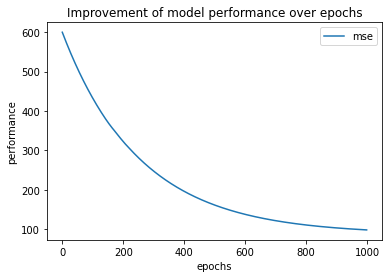

In [89]:
np.random.seed(42) # for reproducible results

regressor = Regressor2()
regressor.train( X, y, learning_rate=1e-6, reg=0.1, num_iters=1000)
print('MSE', regressor.eval(X, y))
plot_history(regressor.history, 'mse')

Training MSE 90.87289009838352
Validation MSE 90.53361244817239


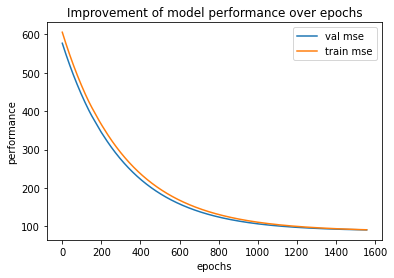

In [90]:
np.random.seed(42) # for reproducible results

# Split dataset into training and validation
X_train, X_val, y_train, y_val = train_test_split(X.T, y.T, test_size=0.2, random_state=42) 
X_train = X_train.T 
X_val = X_val.T
y_train = y_train.T
y_val = y_val.T

# Train with early stopping
regressor2 = Regressor2()
regressor2.train_early_stopping(X_train, y_train, X_val, y_val, learning_rate=1e-6, reg=0.1, early_stopping_rounds=10)
print('Training MSE', regressor2.eval(X_train, y_train))
print('Validation MSE', regressor2.eval(X_val, y_val))
plot_history(regressor2.history, ['val mse', 'train mse'])